<a href="https://colab.research.google.com/github/ABorghini/Speech-Recognition/blob/main/SpeechRecognition_prova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive to Google Colab


In [1]:
# Mount Google Drive
from google.colab import drive 

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [3]:
# ! pip install numpy
# ! conda install -c conda-forge librosa
# ! pip install torchaudio==0.6.0
# ! pip install sentencepiece
# ! pip install pytorch-lightning
# ! pip install hydra-core --upgrade
# ! pip install torch
# ! pip install openspeech-core
# ! pip install jiwer
# ! pip install sentencepiece

In [4]:
#! pip install datasets
# from datasets import load_dataset
import matplotlib.pyplot as plt

import torch 
from torch import Tensor
from torch.utils.data import DataLoader, Sampler
import torch.nn as nn
import torch.nn.init as init

import torchaudio

import numpy as np
import librosa
from tqdm import tqdm
from typing import Tuple, Optional
import os 
import math

import jiwer
import sentencepiece

# Librispeech Dataset

In [5]:
# dataset_clean = load_dataset("librispeech_asr", "clean")
# dataset_other = load_dataset("librispeech_asr", "other")

# train-clean-100 5.95 GB, dev-clean 331 MB, test-clean 
train_clean_100 = torchaudio.datasets.LIBRISPEECH("/content/drive/MyDrive/Speech_Recognition/Librispeech/train-clean-100", url="train-clean-100", download=True)
#train_clean_360 = torchaudio.datasets.LIBRISPEECH("/content/drive/MyDrive/Speech_Recognition/Librispeech/train-clean-3600", url="train-clean-360", download=True)
dev_clean = torchaudio.datasets.LIBRISPEECH("/content/drive/MyDrive/Speech_Recognition/Librispeech/dev-clean", url="dev-clean", download=True)
test_clean = torchaudio.datasets.LIBRISPEECH("/content/drive/MyDrive/Speech_Recognition/Librispeech/test-clean", url="test-clean", download=True)

In [6]:
print(len(train_clean_100))
train_clean_100.__getitem__(0)

28539


(tensor([[-0.0065, -0.0055, -0.0062,  ...,  0.0033,  0.0005, -0.0095]]),
 16000,
 'CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK',
 103,
 1240,
 0)

CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK


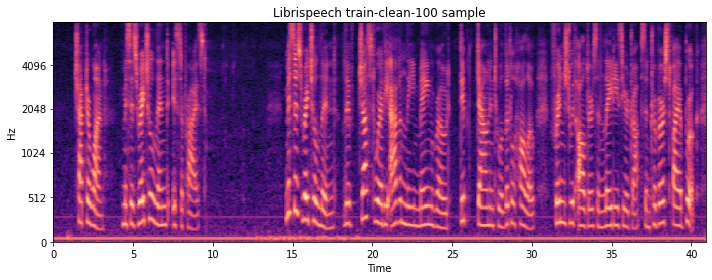

In [7]:
import numpy as np
import librosa.display

sample = train_clean_100.__getitem__(0)
audio = np.array(sample[0])
audio = audio.squeeze(0)
sampling_rate = sample[1]

mel_spectrogram = librosa.feature.melspectrogram(y=audio,
                                                sr=sampling_rate,
                                                n_mels=256,
                                                hop_length=128,
                                                fmax=8000)

# reshape spectrogram shape to [batch_size, time, frequency]
shape = mel_spectrogram.shape
mel_spectrogram = np.reshape(mel_spectrogram, (-1, shape[0], shape[1]))
mel_spectrogram = torch.from_numpy(mel_spectrogram)

print(sample[2])
# Show Raw mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram[0, :, :], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
# plt.colorbar(format='%+2.0f dB')
plt.title("Librispeech train-clean-100 sample")
plt.tight_layout()
plt.show()

## Wav2Vec Model

In [8]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('<s>', '<pad>', '</s>', '<unk>', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [9]:
model = bundle.get_model().to("cuda")

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


# Dataloader

In [10]:
# def _collate_fn(batch, pad_id: int = 0):
#     """
#     Functions that pad to the maximum sequence length
#     Args:
#         batch (tuple): tuple contains input and target tensors
#         pad_id (int): identification of pad token
#     Returns:
#         seqs (torch.FloatTensor): tensor contains input sequences.
#         target (torch.IntTensor): tensor contains target sequences.
#         seq_lengths (torch.IntTensor): tensor contains input sequence lengths
#         target_lengths (torch.IntTensor): tensor contains target sequence lengths
#     """
#     def seq_length_(p):
#         return len(p[0])

#     def target_length_(p):
#         return len(p[1])

#     # sort by sequence length for rnn.pack_padded_sequence()
#     batch = sorted(batch, key=lambda sample: sample[0].size(0), reverse=True)

#     seq_lengths = [len(s[0]) for s in batch]
#     target_lengths = [len(s[1]) - 1 for s in batch]

#     max_seq_sample = max(batch, key=seq_length_)[0]
#     max_target_sample = max(batch, key=target_length_)[1]

#     max_seq_size = max_seq_sample.size(0)
#     max_target_size = len(max_target_sample)

#     feat_size = max_seq_sample.size(1)
#     batch_size = len(batch)

#     seqs = torch.zeros(batch_size, max_seq_size, feat_size)

#     targets = torch.zeros(batch_size, max_target_size).to(torch.long)
#     targets.fill_(pad_id)

#     for x in range(batch_size):
#         sample = batch[x]
#         tensor = sample[0]
#         target = sample[1]
#         seq_length = tensor.size(0)

#         seqs[x].narrow(0, 0, seq_length).copy_(tensor)
#         targets[x].narrow(0, 0, len(target)).copy_(torch.LongTensor(target))

#     seq_lengths = torch.IntTensor(seq_lengths)
#     target_lengths = torch.IntTensor(target_lengths)

#     return seqs, targets, seq_lengths, target_lengths

In [11]:
# class RandomSampler(Sampler):
#     """
#     Implementation of a Random Sampler for sampling the dataset.
#     Args:
#         data_source (torch.utils.data.Dataset): dataset to sample from
#         batch_size (int): size of batch
#         drop_last (bool): flat indication whether to drop last batch or not
#     """
#     def __init__(self, data_source, batch_size: int = 32, drop_last: bool = False) -> None:
#         super(RandomSampler, self).__init__(data_source)
#         self.batch_size = batch_size
#         self.data_source = data_source
#         ids = list(range(0, len(data_source)))
#         self.bins = [ids[i:i + batch_size] for i in tqdm(range(0, len(ids), batch_size))]
#         self.drop_last = drop_last

#     def __iter__(self):
#         for ids in self.bins:
#             np.random.shuffle(ids)
#             yield ids

#     def __len__(self):
#         return len(self.bins)

#     def shuffle(self, epoch):
#         np.random.shuffle(self.bins)

In [12]:
# class AudioDataLoader(DataLoader):
#     """
#     Audio Data Loader
#     Args:
#         dataset (torch.utils.data.Dataset): dataset from which to load the data.
#         num_workers (int): how many subprocesses to use for data loading.
#         batch_sampler (torch.utils.data.sampler.Sampler): defines the strategy to draw samples from the dataset.
#     """
#     def __init__(
#             self,
#             dataset: torch.utils.data.Dataset,
#             num_workers: int,
#             batch_sampler: torch.utils.data.sampler.Sampler,
#             **kwargs,
#     ) -> None:
#         super(AudioDataLoader, self).__init__(
#             dataset=dataset,
#             num_workers=num_workers,
#             batch_sampler=batch_sampler,
#             **kwargs,
#         )
#         self.collate_fn = _collate_fn

## Tokenizer

In [13]:
def create_tokenizer(dataset):

    # LibriSpeech Dataset
    #if training_params["training_dataset"] == "LibriSpeech":

    # Corpus File Path
    corpus_path =  "drive/MyDrive/Speech_Recognition/train_clean_100_corpus.txt"

    # Create Corpus File
    if not os.path.isfile(corpus_path):
        print("Create Corpus File")
        corpus_file = open(corpus_path, "w")
        corpus = ""
        for line in tqdm(dataset):
            corpus_file.write(line[2].lower() + "\n")
        #corpus_file.write(corpus)

    # Train Tokenizer
    print("Training Tokenizer")
    sentencepiece.SentencePieceTrainer.train(input=corpus_path, 
                                             model_prefix="drive/MyDrive/Speech_Recognition/LibriSpeech_bpe_256", 
                                             vocab_size=256, 
                                             character_coverage=1.0, 
                                             model_type="bpe", 
                                             bos_id=-1, 
                                             eos_id=-1, 
                                             unk_surface="")
    print("Training Done")

In [40]:
import sys
def collate_fn_pad(batch):

    # Regular Mode
    if len(batch[0]) == 2:

        # Sorting sequences by lengths
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[1], reverse=True)

        # Pad data sequences
        data = [item[0].squeeze() for item in sorted_batch]
        data_lengths = torch.tensor([len(d) for d in data],dtype=torch.long) 
        data = torch.nn.utils.rnn.pad_sequence(data, batch_first=True, padding_value=0)

        # Pad labels
        target = [item[1] for item in sorted_batch]
        target_lengths = torch.tensor([t.size(0) for t in target],dtype=torch.long)
        target = torch.nn.utils.rnn.pad_sequence(target, batch_first=True, padding_value=0)

        return data, target, data_lengths, target_lengths

    # LM Mode
    elif len(batch[0]) == 1:

        # Sort Batch
        sorted_batch = sorted(batch, key=lambda x: x[0].size(0), reverse=True)
        sorted_batch = [item[0] for item in sorted_batch]

        # Create Labels
        x = torch.nn.utils.rnn.pad_sequence(sorted_batch, batch_first=True, padding_value=0)
        x_len = torch.tensor([t.size(0) for t in sorted_batch], dtype=torch.long)
        y = [torch.cat([item, item.new_zeros(1)]) for item in sorted_batch]
        y = torch.nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=-1)

        return x, x_len, y

    else:

        raise Exception("Batch Format Error")

def prepare_dataset(dataset, tokenizer):

    # LibriSpeech Dataset
    #if training_params["training_dataset"] == "LibriSpeech":

    main_path = "drive/MyDrive/Speech_Recognition/Librispeech/train-clean-100/"

    # Save Labels and lengths
    print("Encoding sequences")
    for i, (audio_array, _, sentence, idx1, idx2, idx3) in enumerate(dataset):

        # Tokenize and Save label
        label = torch.LongTensor(tokenizer.encode(sentence.lower()))
        path = main_path + str(idx1)+"-"+str(idx2)+"-"+"0"*(4-len(str(idx3)))+str(idx3)
        torch.save(label, path+".bpe_256")

        # Save Audio length
        audio_length = audio_array[0].size(0)
        torch.save(audio_length, path + ".flac_len")

        # Save Label length
        label_length = label.size(0)
        torch.save(label_length, path + "_len")

In [41]:
tok_path = "drive/MyDrive/Speech_Recognition/LibriSpeech_bpe_256.model"
#create_tokenizer(train_clean_100)
tokenizer = sentencepiece.SentencePieceProcessor(tok_path)
prepare_dataset(train_clean_100, tokenizer)

Encoding sequences


KeyboardInterrupt: ignored

In [ ]:
# test_sampler = RandomSampler(train_clean_100, batch_size=8)

# train_clean_100_dataloader = AudioDataLoader(dataset=train_clean_100,
#                                              num_workers=1,
#                                              batch_sampler=test_sampler)

## Embeddings

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Positional Encoding proposed in "Attention Is All You Need".
    Since transformer contains no recurrence and no convolution, in order for the model to make
    use of the order of the sequence, we must add some positional information.
    "Attention Is All You Need" use sine and cosine functions of different frequencies:
        PE_(pos, 2i)    =  sin(pos / power(10000, 2i / d_model))
        PE_(pos, 2i+1)  =  cos(pos / power(10000, 2i / d_model))
    """
    def __init__(self, d_model: int = 512, max_len: int = 10000) -> None:
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model, requires_grad=False)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, length: int) -> Tensor:
        return self.pe[:, :length]

# Trainer

In [ ]:
class Trainer():
    def __init__(self,
                 model: nn.Module,
                 loss_function,
                 optimizer,
                 vocabulary):
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.vocabulary = vocabulary
    
    def train(self, 
              train_dataset,
              dev_dataset,
              epochs:int=1):
        
        print("Training...")

        train_loss = 0.0
        total_loss_train = []
        total_loss_dev = []

        for epoch in range(epochs):
            print(" Epoch {:03d}".format(epoch + 1))

            epoch_loss = 0.0

            # train mode on
            self.model.train()

            for things in tqdm(train_dataset):
                self.optimizer.zero_grad()


            ...
            _.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), 1)
            self.optimizer.step()
            epoch_loss += _.tolist()

            avg_epoch_loss = epoch_loss / len(train_dataset)
            print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss, f1 = self.evaluate(dev_dataset)
            print('  [E: {:2d}] valid loss = {:0.4f}, f1-score = {:0.4f}'.format(epoch, valid_loss, f1))

        print("...Done!")
        return avg_epoch_loss

    def evaluate(self,
              dev_dataset):
        

        # eval mode on
        self.model.eval()

        for things in tqdm(dev_dataset):
            with torch.no_grad():
                model_predict
            
            dev_loss += _.tolist()

        # prediction and computation of f1 score
        
        return normalized_loss, f1_score


# Model

## Utils

### Modules

In [ ]:
class ResidualConnectionModule(nn.Module):
    """
    Residual Connection Module.
    outputs = (module(inputs) x module_factor + inputs x input_factor)
    """
    def __init__(self, module: nn.Module, module_factor: float = 1.0, input_factor: float = 1.0):
        super(ResidualConnectionModule, self).__init__()
        self.module = module
        self.module_factor = module_factor
        self.input_factor = input_factor

    def forward(self, inputs: Tensor) -> Tensor:
        return (self.module(inputs) * self.module_factor) + (inputs * self.input_factor)


class Linear(nn.Module):
    """
    Wrapper class of torch.nn.Linear
    Weight initialize by xavier initialization and bias initialize to zeros.
    """
    def __init__(self, in_features: int, out_features: int, bias: bool = True) -> None:
        super(Linear, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        init.xavier_uniform_(self.linear.weight)
        if bias:
            init.zeros_(self.linear.bias)

    def forward(self, x: Tensor) -> Tensor:
        return self.linear(x)


class View(nn.Module):
    """ Wrapper class of torch.view() for Sequential module. """
    def __init__(self, shape: tuple, contiguous: bool = False):
        super(View, self).__init__()
        self.shape = shape
        self.contiguous = contiguous

    def forward(self, x: Tensor) -> Tensor:
        if self.contiguous:
            x = x.contiguous()

        return x.view(*self.shape)


class Transpose(nn.Module):
    """ Wrapper class of torch.transpose() for Sequential module. """
    def __init__(self, shape: tuple):
        super(Transpose, self).__init__()
        self.shape = shape

    def forward(self, x: Tensor) -> Tensor:
        return x.transpose(*self.shape)

### Feed Forward

In [ ]:
class FeedForwardModule(nn.Module):
    """
    Conformer Feed Forward Module follow pre-norm residual units and apply layer normalization within the residual unit
    and on the input before the first linear layer. This module also apply Swish activation and dropout, which helps
    regularizing the network.
    Args:
        encoder_dim (int): Dimension of conformer encoder
        expansion_factor (int): Expansion factor of feed forward module.
        dropout_p (float): Ratio of dropout
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor contains input sequences
    Outputs: outputs
        - **outputs** (batch, time, dim): Tensor produces by feed forward module.
    """
    def __init__(
            self,
            encoder_dim: int = 512,
            expansion_factor: int = 4,
            dropout_p: float = 0.1,
    ) -> None:
        super(FeedForwardModule, self).__init__()
        self.sequential = nn.Sequential(
            nn.LayerNorm(encoder_dim),
            Linear(encoder_dim, encoder_dim * expansion_factor, bias=True),
            Swish(),
            nn.Dropout(p=dropout_p),
            Linear(encoder_dim * expansion_factor, encoder_dim, bias=True),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs)

### Activation Function

In [ ]:
class Swish(nn.Module):
    """
    Swish is a smooth, non-monotonic function that consistently matches or outperforms ReLU on deep networks applied
    to a variety of challenging domains such as Image classification and Machine translation.
    """
    def __init__(self):
        super(Swish, self).__init__()
    
    def forward(self, inputs: Tensor) -> Tensor:
        return inputs * inputs.sigmoid()


class GLU(nn.Module):
    """
    The gating mechanism is called Gated Linear Units (GLU), which was first introduced for natural language processing
    in the paper “Language Modeling with Gated Convolutional Networks”
    """
    def __init__(self, dim: int) -> None:
        super(GLU, self).__init__()
        self.dim = dim

    def forward(self, inputs: Tensor) -> Tensor:
        outputs, gate = inputs.chunk(2, dim=self.dim)
        return outputs * gate.sigmoid()

### Convolution

In [ ]:
class DepthwiseConv1d(nn.Module):
    """
    When groups == in_channels and out_channels == K * in_channels, where K is a positive integer,
    this operation is termed in literature as depthwise convolution.
    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int or tuple): Size of the convolving kernel
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If True, adds a learnable bias to the output. Default: True
    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector
    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by depthwise 1-D convolution.
    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride: int = 1,
            padding: int = 0,
            bias: bool = False,
    ) -> None:
        super(DepthwiseConv1d, self).__init__()
        assert out_channels % in_channels == 0, "out_channels should be constant multiple of in_channels"
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            groups=in_channels,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.conv(inputs)


class PointwiseConv1d(nn.Module):
    """
    When kernel size == 1 conv1d, this operation is termed in literature as pointwise convolution.
    This operation often used to match dimensions.
    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If True, adds a learnable bias to the output. Default: True
    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector
    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by pointwise 1-D convolution.
    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            stride: int = 1,
            padding: int = 0,
            bias: bool = True,
    ) -> None:
        super(PointwiseConv1d, self).__init__()
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.conv(inputs)
        
class ConformerConvModule(nn.Module):
    """
    Conformer convolution module starts with a pointwise convolution and a gated linear unit (GLU).
    This is followed by a single 1-D depthwise convolution layer. Batchnorm is  deployed just after the convolution
    to aid training deep models.
    Args:
        in_channels (int): Number of channels in the input
        kernel_size (int or tuple, optional): Size of the convolving kernel Default: 31
        dropout_p (float, optional): probability of dropout
    Inputs: inputs
        inputs (batch, time, dim): Tensor contains input sequences
    Outputs: outputs
        outputs (batch, time, dim): Tensor produces by conformer convolution module.
    """
    def __init__(
            self,
            in_channels: int,
            kernel_size: int = 31,
            expansion_factor: int = 2,
            dropout_p: float = 0.1,
    ) -> None:
        super(ConformerConvModule, self).__init__()
        assert (kernel_size - 1) % 2 == 0, "kernel_size should be a odd number for 'SAME' padding"
        assert expansion_factor == 2, "Currently, Only Supports expansion_factor 2"

        self.sequential = nn.Sequential(
            nn.LayerNorm(in_channels),
            Transpose(shape=(1, 2)),
            PointwiseConv1d(in_channels, in_channels * expansion_factor, stride=1, padding=0, bias=True),
            GLU(dim=1),
            DepthwiseConv1d(in_channels, in_channels, kernel_size, stride=1, padding=(kernel_size - 1) // 2),
            nn.BatchNorm1d(in_channels),
            Swish(),
            PointwiseConv1d(in_channels, in_channels, stride=1, padding=0, bias=True),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs).transpose(1, 2)

class Conv2dSubampling(nn.Module):
    """
    Convolutional 2D subsampling (to 1/4 length)
    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing sequence of inputs
    Returns: outputs, output_lengths
        - **outputs** (batch, time, dim): Tensor produced by the convolution
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(Conv2dSubampling, self).__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(),
        )

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        outputs = self.sequential(inputs.unsqueeze(1))
        batch_size, channels, subsampled_lengths, sumsampled_dim = outputs.size()

        outputs = outputs.permute(0, 2, 1, 3)
        outputs = outputs.contiguous().view(batch_size, subsampled_lengths, channels * sumsampled_dim)

        output_lengths = input_lengths >> 2
        output_lengths -= 1

        return outputs, output_lengths

### Attention 

In [ ]:
class RelativeMultiHeadAttention(nn.Module):
    """
    Multi-head attention with relative positional encoding.
    This concept was proposed in the "Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context"
    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout
    Inputs: query, key, value, pos_embedding, mask
        - **query** (batch, time, dim): Tensor containing query vector
        - **key** (batch, time, dim): Tensor containing key vector
        - **value** (batch, time, dim): Tensor containing value vector
        - **pos_embedding** (batch, time, dim): Positional embedding tensor
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked
    Returns:
        - **outputs**: Tensor produces by relative multi head attention module.
    """
    def __init__(
            self,
            d_model: int = 512,
            num_heads: int = 16,
            dropout_p: float = 0.1,
    ):
        super(RelativeMultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model % num_heads should be zero."
        self.d_model = d_model
        self.d_head = int(d_model / num_heads)
        self.num_heads = num_heads
        self.sqrt_dim = math.sqrt(d_model)

        self.query_proj = Linear(d_model, d_model)
        self.key_proj = Linear(d_model, d_model)
        self.value_proj = Linear(d_model, d_model)
        self.pos_proj = Linear(d_model, d_model, bias=False)

        self.dropout = nn.Dropout(p=dropout_p)
        self.u_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        self.v_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        torch.nn.init.xavier_uniform_(self.u_bias)
        torch.nn.init.xavier_uniform_(self.v_bias)

        self.out_proj = Linear(d_model, d_model)

    def forward(
            self,
            query: Tensor,
            key: Tensor,
            value: Tensor,
            pos_embedding: Tensor,
            mask: Optional[Tensor] = None,
    ) -> Tensor:
        batch_size = value.size(0)

        query = self.query_proj(query).view(batch_size, -1, self.num_heads, self.d_head)
        key = self.key_proj(key).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        value = self.value_proj(value).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        pos_embedding = self.pos_proj(pos_embedding).view(batch_size, -1, self.num_heads, self.d_head)

        content_score = torch.matmul((query + self.u_bias).transpose(1, 2), key.transpose(2, 3))
        pos_score = torch.matmul((query + self.v_bias).transpose(1, 2), pos_embedding.permute(0, 2, 3, 1))
        pos_score = self._relative_shift(pos_score)

        score = (content_score + pos_score) / self.sqrt_dim

        if mask is not None:
            mask = mask.unsqueeze(1)
            score.masked_fill_(mask, -1e9)

        attn = F.softmax(score, -1)
        attn = self.dropout(attn)

        context = torch.matmul(attn, value).transpose(1, 2)
        context = context.contiguous().view(batch_size, -1, self.d_model)

        return self.out_proj(context)

    def _relative_shift(self, pos_score: Tensor) -> Tensor:
        batch_size, num_heads, seq_length1, seq_length2 = pos_score.size()
        zeros = pos_score.new_zeros(batch_size, num_heads, seq_length1, 1)
        padded_pos_score = torch.cat([zeros, pos_score], dim=-1)

        padded_pos_score = padded_pos_score.view(batch_size, num_heads, seq_length2 + 1, seq_length1)
        pos_score = padded_pos_score[:, :, 1:].view_as(pos_score)

        return pos_score


class MultiHeadedSelfAttentionModule(nn.Module):
    """
    Conformer employ multi-headed self-attention (MHSA) while integrating an important technique from Transformer-XL,
    the relative sinusoidal positional encoding scheme. The relative positional encoding allows the self-attention
    module to generalize better on different input length and the resulting encoder is more robust to the variance of
    the utterance length. Conformer use prenorm residual units with dropout which helps training
    and regularizing deeper models.
    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout
    Inputs: inputs, mask
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked
    Returns:
        - **outputs** (batch, time, dim): Tensor produces by relative multi headed self attention module.
    """
    def __init__(self, d_model: int, num_heads: int, dropout_p: float = 0.1):
        super(MultiHeadedSelfAttentionModule, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        self.attention = RelativeMultiHeadAttention(d_model, num_heads, dropout_p)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, inputs: Tensor, mask: Optional[Tensor] = None):
        batch_size, seq_length, _ = inputs.size()
        pos_embedding = self.positional_encoding(seq_length)
        pos_embedding = pos_embedding.repeat(batch_size, 1, 1)

        inputs = self.layer_norm(inputs)
        outputs = self.attention(inputs, inputs, inputs, pos_embedding=pos_embedding, mask=mask)

        return self.dropout(outputs)

## Conformer

#### Conformer Block

In [ ]:
class ConformerBlock(nn.Module):
    """
    Conformer block contains two Feed Forward modules sandwiching the Multi-Headed Self-Attention module
    and the Convolution module. This sandwich structure is inspired by Macaron-Net, which proposes replacing
    the original feed-forward layer in the Transformer block into two half-step feed-forward layers,
    one before the attention layer and one after.
    Args:
        encoder_dim (int, optional): Dimension of conformer encoder
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing input vector
    Returns: outputs
        - **outputs** (batch, time, dim): Tensor produces by conformer block.
    """
    def __init__(
            self,
            encoder_dim: int = 512,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ):
        super(ConformerBlock, self).__init__()
        if half_step_residual:
            self.feed_forward_residual_factor = 0.5
        else:
            self.feed_forward_residual_factor = 1

        self.sequential = nn.Sequential(
            ResidualConnectionModule(
                module=FeedForwardModule(
                    encoder_dim=encoder_dim,
                    expansion_factor=feed_forward_expansion_factor,
                    dropout_p=feed_forward_dropout_p,
                ),
                module_factor=self.feed_forward_residual_factor,
            ),
            ResidualConnectionModule(
                module=MultiHeadedSelfAttentionModule(
                    d_model=encoder_dim,
                    num_heads=num_attention_heads,
                    dropout_p=attention_dropout_p,
                ),
            ),
            ResidualConnectionModule(
                module=ConformerConvModule(
                    in_channels=encoder_dim,
                    kernel_size=conv_kernel_size,
                    expansion_factor=conv_expansion_factor,
                    dropout_p=conv_dropout_p,
                ),
            ),
            ResidualConnectionModule(
                module=FeedForwardModule(
                    encoder_dim=encoder_dim,
                    expansion_factor=feed_forward_expansion_factor,
                    dropout_p=feed_forward_dropout_p,
                ),
                module_factor=self.feed_forward_residual_factor,
            ),
            nn.LayerNorm(encoder_dim),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs)

#### Encoder

In [ ]:
class ConformerEncoder(nn.Module):
    """
    Conformer encoder first processes the input with a convolution subsampling layer and then
    with a number of conformer blocks.
    Args:
        input_dim (int, optional): Dimension of input vector
        encoder_dim (int, optional): Dimension of conformer encoder
        num_layers (int, optional): Number of conformer blocks
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
    Inputs: inputs, input_lengths
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths
    Returns: outputs, output_lengths
        - **outputs** (batch, out_channels, time): Tensor produces by conformer encoder.
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(
            self,
            input_dim: int = 80,
            encoder_dim: int = 512,
            num_layers: int = 17,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            input_dropout_p: float = 0.1,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ):
        super(ConformerEncoder, self).__init__()
        self.conv_subsample = Conv2dSubampling(in_channels=1, out_channels=encoder_dim)
        self.input_projection = nn.Sequential(
            Linear(encoder_dim * (((input_dim - 1) // 2 - 1) // 2), encoder_dim),
            nn.Dropout(p=input_dropout_p),
        )
        self.layers = nn.ModuleList([ConformerBlock(
            encoder_dim=encoder_dim,
            num_attention_heads=num_attention_heads,
            feed_forward_expansion_factor=feed_forward_expansion_factor,
            conv_expansion_factor=conv_expansion_factor,
            feed_forward_dropout_p=feed_forward_dropout_p,
            attention_dropout_p=attention_dropout_p,
            conv_dropout_p=conv_dropout_p,
            conv_kernel_size=conv_kernel_size,
            half_step_residual=half_step_residual,
        ) for _ in range(num_layers)])

    def count_parameters(self) -> int:
        """ Count parameters of encoder """
        return sum([p.numel for p in self.parameters()])

    def update_dropout(self, dropout_p: float) -> None:
        """ Update dropout probability of encoder """
        for name, child in self.named_children():
            if isinstance(child, nn.Dropout):
                child.p = dropout_p

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Forward propagate a `inputs` for  encoder training.
        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``
        Returns:
            (Tensor, Tensor)
            * outputs (torch.FloatTensor): A output sequence of encoder. `FloatTensor` of size
                ``(batch, seq_length, dimension)``
            * output_lengths (torch.LongTensor): The length of output tensor. ``(batch)``
        """
        outputs, output_lengths = self.conv_subsample(inputs, input_lengths)
        outputs = self.input_projection(outputs)

        for layer in self.layers:
            outputs = layer(outputs)

        return outputs, output_lengths

#### Decoder

In [ ]:
class DecoderRNNT(nn.Module):
    """
    Decoder of RNN-Transducer
    Args:
        num_classes (int): number of classification
        hidden_state_dim (int, optional): hidden state dimension of decoder (default: 512)
        output_dim (int, optional): output dimension of encoder and decoder (default: 512)
        num_layers (int, optional): number of decoder layers (default: 1)
        rnn_type (str, optional): type of rnn cell (default: lstm)
        sos_id (int, optional): start of sentence identification
        eos_id (int, optional): end of sentence identification
        dropout_p (float, optional): dropout probability of decoder
    Inputs: inputs, input_lengths
        inputs (torch.LongTensor): A target sequence passed to decoder. `IntTensor` of size ``(batch, seq_length)``
        input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``
        hidden_states (torch.FloatTensor): A previous hidden state of decoder. `FloatTensor` of size
            ``(batch, seq_length, dimension)``
    Returns:
        (Tensor, Tensor):
        * decoder_outputs (torch.FloatTensor): A output sequence of decoder. `FloatTensor` of size
            ``(batch, seq_length, dimension)``
        * hidden_states (torch.FloatTensor): A hidden state of decoder. `FloatTensor` of size
            ``(batch, seq_length, dimension)``
    """
    supported_rnns = {
        'lstm': nn.LSTM,
        'gru': nn.GRU,
        'rnn': nn.RNN,
    }

    def __init__(
            self,
            num_classes: int,
            hidden_state_dim: int,
            output_dim: int,
            num_layers: int,
            rnn_type: str = 'lstm',
            sos_id: int = 1,
            eos_id: int = 2,
            dropout_p: float = 0.2,
    ):
        super(DecoderRNNT, self).__init__()
        self.hidden_state_dim = hidden_state_dim
        self.sos_id = sos_id
        self.eos_id = eos_id
        self.embedding = nn.Embedding(num_classes, hidden_state_dim)
        rnn_cell = self.supported_rnns[rnn_type.lower()]
        self.rnn = rnn_cell(
            input_size=hidden_state_dim,
            hidden_size=hidden_state_dim,
            num_layers=num_layers,
            bias=True,
            batch_first=True,
            dropout=dropout_p,
            bidirectional=False,
        )
        self.out_proj = Linear(hidden_state_dim, output_dim)

    def count_parameters(self) -> int:
        """ Count parameters of encoder """
        return sum([p.numel for p in self.parameters()])

    def update_dropout(self, dropout_p: float) -> None:
        """ Update dropout probability of encoder """
        for name, child in self.named_children():
            if isinstance(child, nn.Dropout):
                child.p = dropout_p

    def forward(
            self,
            inputs: Tensor,
            input_lengths: Tensor = None,
            hidden_states: Tensor = None,
    ) -> Tuple[Tensor, Tensor]:
        """
        Forward propage a `inputs` (targets) for training.
        Args:
            inputs (torch.LongTensor): A target sequence passed to decoder. `IntTensor` of size ``(batch, seq_length)``
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``
            hidden_states (torch.FloatTensor): A previous hidden state of decoder. `FloatTensor` of size
                ``(batch, seq_length, dimension)``
        Returns:
            (Tensor, Tensor):
            * decoder_outputs (torch.FloatTensor): A output sequence of decoder. `FloatTensor` of size
                ``(batch, seq_length, dimension)``
            * hidden_states (torch.FloatTensor): A hidden state of decoder. `FloatTensor` of size
                ``(batch, seq_length, dimension)``
        """
        embedded = self.embedding(inputs)

        if input_lengths is not None:
            embedded = nn.utils.rnn.pack_padded_sequence(embedded.transpose(0, 1), input_lengths.cpu())
            outputs, hidden_states = self.rnn(embedded, hidden_states)
            outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
            outputs = self.out_proj(outputs.transpose(0, 1))
        else:
            outputs, hidden_states = self.rnn(embedded, hidden_states)
            outputs = self.out_proj(outputs)

        return outputs, hidden_states

#### Conformer Model

In [ ]:
class Conformer(nn.Module):
    """
    Conformer: Convolution-augmented Transformer for Speech Recognition
    The paper used a one-lstm Transducer decoder, currently still only implemented
    the conformer encoder shown in the paper.
    Args:
        hparams: HParams
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths
    Returns: outputs, output_lengths
        - **outputs** (batch, out_channels, time): Tensor produces by conformer.
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(
            self,
            hparams
    ) -> None:
        super(Conformer, self).__init__()
        self.encoder = ConformerEncoder(
            input_dim=hparams.input_dim,
            encoder_dim=hparams.encoder_dim,
            num_layers=hparams.num_encoder_layers,
            num_attention_heads=hparams.num_attention_heads,
            feed_forward_expansion_factor=hparams.feed_forward_expansion_factor,
            conv_expansion_factor=hparams.conv_expansion_factor,
            input_dropout_p=hparams.input_dropout_p,
            feed_forward_dropout_p=hparams.feed_forward_dropout_p,
            attention_dropout_p=hparams.attention_dropout_p,
            conv_dropout_p=hparams.conv_dropout_p,
            conv_kernel_size=hparams.conv_kernel_size,
            half_step_residual=hparams.half_step_residual,
        )
        self.decoder = DecoderRNNT(
            num_classes=hparams.num_classes,
            hidden_state_dim=hparams.decoder_dim,
            output_dim=hparams.encoder_dim,
            num_layers=hparams.num_decoder_layers,
            rnn_type=hparams.decoder_rnn_type,
            dropout_p=hparams.decoder_dropout_p,
        )
        self.fc = Linear(hparams.encoder_dim << 1, hparams.num_classes, bias=False)

    def set_encoder(self, encoder):
        """ Setter for encoder """
        self.encoder = encoder

    def set_decoder(self, decoder):
        """ Setter for decoder """
        self.decoder = decoder

    def count_parameters(self) -> int:
        """ Count parameters of encoder """
        num_encoder_parameters = self.encoder.count_parameters()
        num_decoder_parameters = self.decoder.count_parameters()
        return num_encoder_parameters + num_decoder_parameters

    def update_dropout(self, dropout_p) -> None:
        """ Update dropout probability of model """
        self.encoder.update_dropout(dropout_p)
        self.decoder.update_dropout(dropout_p)

    def joint(self, encoder_outputs: Tensor, decoder_outputs: Tensor) -> Tensor:
        """
        Joint `encoder_outputs` and `decoder_outputs`.
        Args:
            encoder_outputs (torch.FloatTensor): A output sequence of encoder. `FloatTensor` of size
                ``(batch, seq_length, dimension)``
            decoder_outputs (torch.FloatTensor): A output sequence of decoder. `FloatTensor` of size
                ``(batch, seq_length, dimension)``
        Returns:
            * outputs (torch.FloatTensor): outputs of joint `encoder_outputs` and `decoder_outputs`..
        """
        if encoder_outputs.dim() == 3 and decoder_outputs.dim() == 3:
            input_length = encoder_outputs.size(1)
            target_length = decoder_outputs.size(1)

            encoder_outputs = encoder_outputs.unsqueeze(2)
            decoder_outputs = decoder_outputs.unsqueeze(1)

            encoder_outputs = encoder_outputs.repeat([1, 1, target_length, 1])
            decoder_outputs = decoder_outputs.repeat([1, input_length, 1, 1])

        outputs = torch.cat((encoder_outputs, decoder_outputs), dim=-1)
        outputs = self.fc(outputs)

        return outputs

    def forward(
            self,
            inputs: Tensor,
            input_lengths: Tensor,
            targets: Tensor,
            target_lengths: Tensor
    ) -> Tensor:
        """
        Forward propagate a `inputs` and `targets` pair for training.
        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``
            targets (torch.LongTensr): A target sequence passed to decoder. `IntTensor` of size ``(batch, seq_length)``
            target_lengths (torch.LongTensor): The length of target tensor. ``(batch)``
        Returns:
            * predictions (torch.FloatTensor): Result of model predictions.
        """
        encoder_outputs, _ = self.encoder(inputs, input_lengths)
        decoder_outputs, _ = self.decoder(targets, target_lengths)
        outputs = self.joint(encoder_outputs, decoder_outputs)
        return outputs

    @torch.no_grad()
    def decode(self, encoder_output: Tensor, max_length: int) -> Tensor:
        """
        Decode `encoder_outputs`.
        Args:
            encoder_output (torch.FloatTensor): A output sequence of encoder. `FloatTensor` of size
                ``(seq_length, dimension)``
            max_length (int): max decoding time step
        Returns:
            * predicted_log_probs (torch.FloatTensor): Log probability of model predictions.
        """
        pred_tokens, hidden_state = list(), None
        decoder_input = encoder_output.new_tensor([[self.decoder.sos_id]], dtype=torch.long)

        for t in range(max_length):
            decoder_output, hidden_state = self.decoder(decoder_input, hidden_states=hidden_state)
            step_output = self.joint(encoder_output[t].view(-1), decoder_output.view(-1))
            step_output = step_output.softmax(dim=0)
            pred_token = step_output.argmax(dim=0)
            pred_token = int(pred_token.item())
            pred_tokens.append(pred_token)
            decoder_input = step_output.new_tensor([[pred_token]], dtype=torch.long)

        return torch.LongTensor(pred_tokens)

    @torch.no_grad()
    def recognize(self, inputs: Tensor, input_lengths: Tensor):
        """
        Recognize input speech. This method consists of the forward of the encoder and the decode() of the decoder.
        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``
        Returns:
            * predictions (torch.FloatTensor): Result of model predictions.
        """
        outputs = list()

        encoder_outputs, output_lengths = self.encoder(inputs, input_lengths)
        max_length = encoder_outputs.size(1)

        for encoder_output in encoder_outputs:
            decoded_seq = self.decode(encoder_output, max_length)
            outputs.append(decoded_seq)

        outputs = torch.stack(outputs, dim=1).transpose(0, 1)

        return outputs

## Hyperparameters and Model initialization

In [ ]:
class HParams():
    """       
    HParams: Hyperparameters needed to initialize the Conformer model     
    Args:
        num_classes (int): Number of classification classes
        input_dim (int, optional): Dimension of input vector
        encoder_dim (int, optional): Dimension of conformer encoder
        decoder_dim (int, optional): Dimension of conformer decoder
        num_encoder_layers (int, optional): Number of conformer blocks
        num_decoder_layers (int, optional): Number of decoder layers
        decoder_rnn_type (str, optional): type of RNN cell
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        decoder_dropout_p (float, optional): Probability of conformer decoder dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
    """
    num_classes: int = 29
    input_dim: int = 80
    encoder_dim: int = 512
    decoder_dim: int = 640
    num_encoder_layers: int = 17
    num_decoder_layers: int = 1
    num_attention_heads: int = 8
    feed_forward_expansion_factor: int = 4
    conv_expansion_factor: int = 2
    input_dropout_p: float = 0.1
    feed_forward_dropout_p: float = 0.1
    attention_dropout_p: float = 0.1
    conv_dropout_p: float = 0.1
    decoder_dropout_p: float = 0.1
    conv_kernel_size: int = 31
    half_step_residual: bool = True
    decoder_rnn_type: str = "lstm"

params = HParams()

In [ ]:
model = Conformer(params)

# Training

# [NO] Decoder (transcription)

In [ ]:
# Model classification 
#waveform = train_clean_100[0][0].to("cuda")
with torch.inference_mode():
  emission, _ = model(train_clean_100_dataloader)

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
  def __init__(self, labels, blank=0):
    super().__init__()
    self.labels = labels
    self.blank = blank

  def forward(self, emission: torch.Tensor) -> str:
    """Given a sequence emission over labels, get the best path string
    Args:
      emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

    Returns:
      str: The resulting transcript
    """
    indices = torch.argmax(emission, dim=-1)  # [num_seq,]
    indices = torch.unique_consecutive(indices, dim=-1)
    indices = [i for i in indices if i != self.blank]
    return ''.join([self.labels[i] for i in indices])

In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [ ]:
print(transcript)
print(train_clean_100[0][2])